In [11]:
# %% [code]
import os
import json
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from typing import Dict, List, Tuple, Optional

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score

# Optional boosters
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# you can force-disable if LGBM is noisy:
HAS_LGBM = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except Exception:
    HAS_CAT = False

# --- Config ---
DATA_PATH    = "data/housing_adequacy_dataset.csv"
SPLIT_POINT  = "2020Q1"          # train < split, test >= split
RANDOM_STATE = 42

PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]
PROVINCE_NAMES = {
    "can": "Canada", "nl": "Newfoundland and Labrador", "pe": "Prince Edward Island",
    "ns": "Nova Scotia", "nb": "New Brunswick", "qc": "Quebec", "on": "Ontario",
    "mb": "Manitoba", "sk": "Saskatchewan", "ab": "Alberta", "bc": "British Columbia"
}

sns.set_style("whitegrid")
sns.set_context("notebook")
plt.rcParams["figure.dpi"] = 120


In [12]:
# %% [code]
def mae(y_true, y_pred):  return float(np.mean(np.abs(y_true - y_pred)))
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred)**2)))
def smape(y_true, y_pred, eps=1e-12):
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return float(np.mean(2.0*np.abs(y_pred - y_true)/denom))

def mase(y_true, y_pred, y_train, seasonality=4):
    y_train = np.asarray(y_train)
    if len(y_train) <= seasonality: return np.nan
    diffs = np.abs(y_train[seasonality:] - y_train[:-seasonality])
    scale = np.mean(diffs) if len(diffs) else np.nan
    if scale == 0 or np.isnan(scale): return np.nan
    return mae(y_true, y_pred) / scale

def _to_dt(q):
    import pandas as pd
    if isinstance(q, (pd.PeriodIndex, pd.Index)) and getattr(q, "freq", None) is not None:
        return q.to_timestamp()
    if isinstance(q, pd.Series):
        if pd.api.types.is_period_dtype(q.dtype):
            return q.dt.to_timestamp()
        return pd.to_datetime(q, errors="coerce")
    return pd.to_datetime(q, errors="coerce")

def chrono_split(dfX: pd.DataFrame, split_point: str):
    tr = dfX[dfX["quarter"] < split_point].copy()
    te = dfX[dfX["quarter"] >= split_point].copy()
    return tr, te


In [13]:
# %% [code]
assert os.path.exists(DATA_PATH), f"Missing {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df = df.sort_values(["province","quarter"]).reset_index(drop=True)

print("Shape:", df.shape)
display(df.head())


Shape: (1573, 9)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai
0,1990Q1,ab,2520056.0,23.421667,5.855417,5855.416667,NaN,NaN,0.000000
1,1990Q2,ab,2532621.0,21.490333,5.372583,5372.583333,12565.0,5026.0,1.068958
2,1990Q3,ab,2547788.0,13.847000,3.461750,3461.750000,15167.0,6066.8,0.570606
3,1990Q4,ab,2563142.0,11.723333,2.930833,2930.833333,15354.0,6141.6,0.477210
4,1991Q1,ab,2572947.0,8.494667,2.123667,2123.666667,9805.0,3922.0,0.541475


In [14]:
# %% [code]
TARGET = "hai"  # <-- predicting HAI now

def add_lags(df, cols: List[str], lags: List[int]) -> pd.DataFrame:
    out = df.sort_values(["province","quarter"]).copy()
    for col in cols:
        for l in lags:
            out[f"{col}_lag{l}"] = out.groupby("province")[col].shift(l)
    return out

def add_calendar(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["year"] = out["quarter"].dt.year
    qnum = out["quarter"].dt.quarter
    q_dummies = pd.get_dummies(qnum, prefix="q", drop_first=True)
    return pd.concat([out, q_dummies], axis=1)

def add_rollings_causal(df: pd.DataFrame, windows=(4,)):
    out = df.copy()
    for w in windows:
        # causal rolling means (shifted by 1)
        out[f"hai_ma{w}"] = out.groupby("province")["hai"] \
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        out[f"need_ma{w}"] = out.groupby("province")["needed_units_q"] \
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        out[f"pop_ma{w}"] = out.groupby("province")["pop_change_q"] \
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
    return out

def sanitize(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    out.replace([np.inf, -np.inf], np.nan, inplace=True)
    return out

# Build causal features that avoid leakage:
# - NO contemporaneous starts in features (starts is in HAI numerator)
# - We allow contemporaneous needed_units_q and pop_change_q if you can forecast/provide them;
#   otherwise switch to lags only.
base = df.copy()
base = add_lags(base, ["hai","pop_change_q","needed_units_q","starts_saar_q"], lags=[1,4])
base = add_calendar(base)
base = add_rollings_causal(base, windows=(4,))
base["province_code"] = base["province"].astype("category").cat.codes

# Minimal, robust set (you can extend later)
BASE_FEATS = [
    "pop_change_q","needed_units_q",           # if exogenous/future-known; else drop these two
    "hai_lag1","hai_lag4",                     # strong auto-dependence
    "pop_change_q_lag1","needed_units_q_lag1", # safe lags
    "starts_saar_q_lag1","starts_saar_q_lag4",# past construction momentum only
    "year","q_2","q_3","q_4",
    "hai_ma4","need_ma4","pop_ma4"
]
POOLED_FEATS = BASE_FEATS + ["province_code"]

# Drop rows where target is missing or denom near-zero created NaNs
df_feat = sanitize(base, list(set(POOLED_FEATS+[TARGET])))
df_feat = df_feat.dropna(subset=[TARGET])  # need target to train/evaluate
print("Feature shape:", df_feat.shape)
display(df_feat.tail(3))


Feature shape: (1573, 25)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,hai_lag1,...,starts_saar_q_lag1,starts_saar_q_lag4,year,q_2,q_3,q_4,hai_ma4,need_ma4,pop_ma4,province_code
1570,2025Q1,sk,1261524.0,6.101667,1.525417,1525.416667,4541.0,1816.4,0.839802,0.314774,...,1.147667,0.840583,2025,False,False,False,0.306041,3483.1,8707.75,10
1571,2025Q2,sk,1264537.0,6.118667,1.529667,1529.666667,3013.0,1205.2,1.269222,0.839802,...,1.525417,0.883333,2025,True,False,False,0.451640,3120.8,7802.00,10
1572,2025Q3,sk,1266959.0,5.009000,1.252250,1252.250000,2422.0,968.8,1.292578,1.269222,...,1.529667,1.429083,2025,False,True,False,0.702228,2594.6,6486.50,10


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.Pe

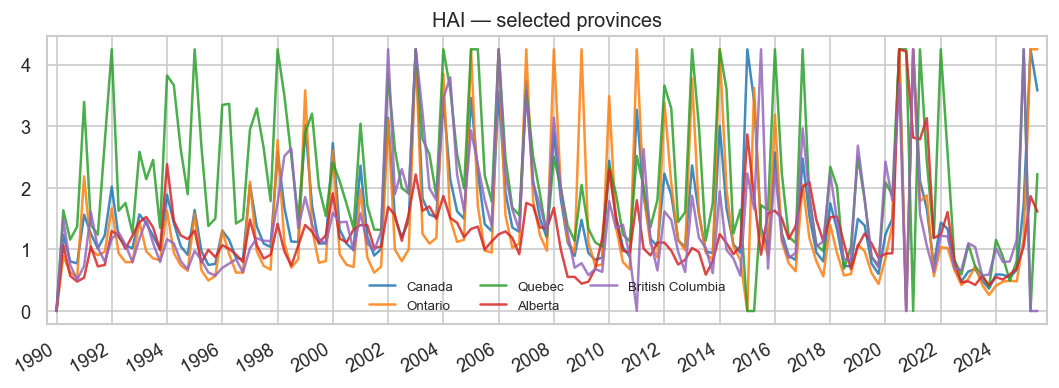

In [15]:
# %% [code]
def quick_overlay(df, col, provinces=None, title=None):
    provinces = provinces or PROVINCES_ORDER
    plt.figure(figsize=(9,3.4))
    for p in provinces:
        sub = df[df["province"]==p].sort_values("quarter")
        if sub.empty: continue
        plt.plot(_to_dt(sub["quarter"]), sub[col], alpha=0.85, lw=1.5, label=PROVINCE_NAMES.get(p,p))
    plt.title(title or col); plt.margins(x=0.01)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    if len(provinces)<=6: plt.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

quick_overlay(df, "hai", provinces=["can","on","qc","ab","bc"], title="HAI — selected provinces")


In [16]:
# %% [code]
def registry_models():
    models = {
        # Linear / robust
        "lr":       Pipeline([("scaler", StandardScaler()), ("m", LinearRegression())]),
        "ridge":    Pipeline([("scaler", StandardScaler()), ("m", Ridge())]),
        "lasso":    Pipeline([("scaler", StandardScaler()), ("m", Lasso(max_iter=5000, random_state=RANDOM_STATE))]),
        "enet":     Pipeline([("scaler", StandardScaler()), ("m", ElasticNet(max_iter=5000, random_state=RANDOM_STATE))]),
        "huber":    Pipeline([("scaler", StandardScaler()), ("m", HuberRegressor(max_iter=5000))]),

        # Ensembles
        "rf":         RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1),
        "extratrees": ExtraTreesRegressor(n_estimators=700, random_state=RANDOM_STATE, n_jobs=-1),
        "gbr":        GradientBoostingRegressor(n_estimators=800, learning_rate=0.03, max_depth=3, random_state=RANDOM_STATE),

        # Kernel / instance
        "svr":      Pipeline([("scaler", StandardScaler()), ("m", SVR())]),
        "knn":      Pipeline([("scaler", StandardScaler()), ("m", KNeighborsRegressor())]),
    }
    if HAS_XGB:
        models["xgb"] = XGBRegressor(
            n_estimators=1000, learning_rate=0.03, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1
        )
    if HAS_LGBM:
        models["lgbm"] = lgb.LGBMRegressor(
            n_estimators=1200, learning_rate=0.03, subsample=0.9,
            colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1
        )
    if HAS_CAT:
        models["cat"] = CatBoostRegressor(
            depth=6, learning_rate=0.05, iterations=1200, random_seed=RANDOM_STATE, verbose=False, loss_function="MAE"
        )
    return models

def default_grids():
    grids = {
        # Linear family (pipeline step is "m__...")
        "ridge": {"m__alpha": np.logspace(-3,3,13)},
        "lasso": {"m__alpha": np.logspace(-4,1,12)},
        "enet":  {"m__alpha": np.logspace(-4,1,10), "m__l1_ratio": [0.2,0.5,0.8,1.0]},
        "huber": {"m__epsilon": [1.1, 1.35, 1.5], "m__alpha": [0.0, 0.0001, 0.001]},

        # Ensembles
        "rf":         {"n_estimators": [400,700,1000], "max_depth": [None, 8, 14], "min_samples_leaf": [1,2,4]},
        "extratrees": {"n_estimators": [500,800,1100], "max_depth": [None, 10, 16], "min_samples_leaf": [1,2,4]},
        "gbr":        {"n_estimators":[600,800,1200], "learning_rate":[0.02,0.03,0.05], "max_depth":[2,3]},

        # Kernel / instance-based
        "svr": {"m__C":[0.5,1,2,4], "m__epsilon":[0.05,0.1,0.2], "m__gamma":["scale","auto"]},
        "knn": {"m__n_neighbors":[3,5,7,9], "m__weights":["uniform","distance"]},
    }
    if HAS_XGB:
        grids["xgb"] = {"n_estimators":[800,1200,1600], "max_depth":[4,5,6], "learning_rate":[0.02,0.03,0.05], "subsample":[0.7,0.9]}
    if HAS_LGBM:
        grids["lgbm"] = {"n_estimators":[800,1200,1600], "num_leaves":[31,63,127], "learning_rate":[0.02,0.03]}
    if HAS_CAT:
        grids["cat"] = {"depth":[6,8], "iterations":[800,1200,1600], "learning_rate":[0.03,0.05]}
    return grids

def ts_cv(n_splits=5):  # expanding-window CV
    return TimeSeriesSplit(n_splits=n_splits)

def tune_model(estimator, param_grid, X, y, cv=None, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0):
    cv = cv or ts_cv()
    gs = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose)
    gs.fit(X, y)
    return gs


In [17]:
# %% [code]
CACHE_FILE = "model_tuned_params_cache_hai.json"  # separate cache for HAI

def _load_cache(path=CACHE_FILE) -> Dict:
    if os.path.exists(path):
        try:
            with open(path, "r") as f:
                return json.load(f)
        except Exception:
            return {}
    return {}

def _save_cache(cache_dict: Dict, path=CACHE_FILE):
    with open(path, "w") as f:
        json.dump(cache_dict, f, indent=2)

PARAM_CACHE = _load_cache()

def _feature_sig(feature_cols: List[str]) -> str:
    joined = "|".join(sorted(feature_cols))
    return hashlib.md5(joined.encode("utf-8")).hexdigest()[:8]

def _cache_key(scope: str, model_name: str, split_point: str, feature_cols: List[str]) -> str:
    return f"{scope}::{model_name}::{split_point}::{_feature_sig(feature_cols)}"

def get_cached_or_tune(
    model_name: str,
    scope: str,  # "pooled" or province code
    est,
    grid: dict,
    X_tr,
    y_tr,
    feature_cols: List[str],
    split_point: str,
    scoring="neg_mean_absolute_error",
    force_retrain: bool = False
):
    key = _cache_key(scope, model_name, split_point, feature_cols)

    if (not force_retrain) and (key in PARAM_CACHE):
        best_params = PARAM_CACHE[key]
        try:
            est.set_params(**best_params)
        except Exception:
            gs = tune_model(est, grid, X_tr, y_tr, scoring=scoring, n_jobs=-1, verbose=0)
            best_params = gs.best_params_
            PARAM_CACHE[key] = best_params
            _save_cache(PARAM_CACHE)
            return gs.best_estimator_, best_params, False
        est.fit(X_tr, y_tr)
        return est, best_params, True

    gs = tune_model(est, grid, X_tr, y_tr, scoring=scoring, n_jobs=-1, verbose=0)
    best_params = gs.best_params_
    PARAM_CACHE[key] = best_params
    _save_cache(PARAM_CACHE)
    return gs.best_estimator_, best_params, False


In [22]:
# %% [code]
MODEL_COLORS = {
    "lr": "#1f77b4", "ridge": "#2ca02c", "lasso": "#17becf", "enet": "#ff7f0e", "huber": "#bcbd22",
    "rf": "#9467bd", "extratrees": "#7f7f7f", "gbr": "#8c564b",
    "svr": "#e377c2", "knn": "#d62728",
    "xgb": "#2b8cbe", "lgbm": "#41ab5d", "cat": "#fd8d3c"
}

def plot_scatter_actual_pred(y_true, y_pred, title="Actual vs Predicted"):
    lims = [np.nanmin([y_true.min(), y_pred.min()]), np.nanmax([y_true.max(), y_pred.max()])]
    plt.figure(figsize=(4.8,4.2))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot(lims, lims, 'k--', lw=1)
    plt.xlim(lims); plt.ylim(lims)
    plt.title(title + f"\nMAE={mae(y_true,y_pred):.3f}, RMSE={rmse(y_true,y_pred):.3f}, R²={r2_score(y_true,y_pred):.3f}")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.tight_layout(); plt.show()

def plot_model_bars(metrics_df: pd.DataFrame, title="MASE by model"):
    fig, ax = plt.subplots(figsize=(9.5,4))
    tmp = metrics_df.copy()
    tmp["who"] = tmp.get("province", "pooled")
    sns.barplot(data=tmp, x="who", y="MASE", hue="model", ax=ax)
    ax.axhline(1.0, color="gray", ls="--", lw=1, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(""); ax.set_ylabel("MASE (lower is better)")
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

def overlay_models_one_province(df_all, preds_store, province, models: List[str], title_suffix=""):
    if province not in preds_store:
        print(f"No preds for province {province}"); return
    first = next((preds_store[province][m] for m in models if m in preds_store[province]), None)
    if first is None:
        print("None of the requested models have predictions stored."); return

    tr_idx, te_idx = first["idx_tr"], first["idx_te"]
    tr = df_all.loc[tr_idx].sort_values("quarter")
    te = df_all.loc[te_idx].sort_values("quarter")
    x_tr = _to_dt(tr["quarter"]); y_tr = tr[TARGET].values
    x_te = _to_dt(te["quarter"]); y_te = te[TARGET].values

    plt.figure(figsize=(9,3.2))
    ax = plt.gca()
    ax.plot(x_tr, y_tr, color="black", lw=2, label="Actual (train)")
    ax.plot(x_te, y_te, color="black", lw=2, label="Actual (test)")

    for m in models:
        if m not in preds_store[province]: 
            continue
        rec = preds_store[province][m]
        yhat_tr = rec["yhat_tr"][np.argsort(tr.index)]
        yhat_te = rec["yhat_te"][np.argsort(te.index)]
        color = MODEL_COLORS.get(m.split("(")[0], None)
        ax.plot(x_tr, yhat_tr, lw=1, color=color, label=f"{m} (train)")
        ax.plot(x_te, yhat_te, lw=1, ls="--", color=color, label=f"{m} (test)")

    ax.axvline(x_te.min(), color="gray", ls="--", lw=1, alpha=0.7)
    prov_name = PROVINCE_NAMES.get(province, province)
    ax.set_title(f"{prov_name} — HAI models overlay {title_suffix}")
    ax.set_ylabel("HAI (dimensionless)")
    ax.margins(x=0.01)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

def overlay_models_pooled(df_all, pooled_preds_store, models: List[str], title_suffix=""):
    if "pooled" not in pooled_preds_store:
        print("No pooled predictions"); return
    first_key = next((m for m in models if m in pooled_preds_store["pooled"]), None)
    if first_key is None:
        print("None of the requested pooled models found."); return

    base = pooled_preds_store["pooled"][first_key]
    te = df_all.loc[base["idx_te"]].copy().sort_values(["quarter"])
    # Actual national aggregate (test)
    nat_actual = te.groupby("quarter")[[TARGET]].sum().reset_index().sort_values("quarter")
    x = _to_dt(nat_actual["quarter"]); y_actual = nat_actual[TARGET].values

    plt.figure(figsize=(9,3.2))
    ax = plt.gca()
    ax.plot(x, y_actual, color="black", lw=2, label="Actual (test sum)")

    # models
    for m in models:
        if m not in pooled_preds_store["pooled"]: 
            continue
        rec = pooled_preds_store["pooled"][m]
        # test
        te_m = df_all.loc[rec["idx_te"]].copy()
        te_m["pred"] = rec["yhat_te"]
        nat_pred = te_m.groupby("quarter")[["pred"]].sum().reset_index().sort_values("quarter")
        ax.plot(_to_dt(nat_pred["quarter"]), nat_pred["pred"], lw=1, ls="--",
                color=MODEL_COLORS.get(m.split("(")[0], None), label=f"{m} (test)")
        # train
        tr_m = df_all.loc[rec["idx_tr"]].copy()
        tr_m["pred"] = rec["yhat_tr"]
        nat_pred_tr = tr_m.groupby("quarter")[["pred"]].sum().reset_index().sort_values("quarter")
        ax.plot(_to_dt(nat_pred_tr["quarter"]), nat_pred_tr["pred"], lw=1,
                color=MODEL_COLORS.get(m.split("(")[0], None), alpha=0.95, label=f"{m} (train)")

    split_ts = pd.Period(SPLIT_POINT, freq="Q").to_timestamp()
    ax.axvline(split_ts, color="gray", ls="--", lw=1, alpha=0.7)
    ax.set_title(f"Pooled — National aggregate — Multi-model overlay {title_suffix}")
    ax.set_ylabel(TARGET + " (thousands/quarter)")
    ax.margins(x=0.01)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

In [19]:
# %% [code]
def run_per_province(
    df_feat: pd.DataFrame,
    feature_cols: List[str],
    split_point=SPLIT_POINT,
    do_tune=True,
    models_to_try=("ridge","gbr","rf","lr"),
    force_retrain: bool = False,
    score_metric: str = "neg_mean_absolute_error"
):
    reg_all = registry_models()
    grids   = default_grids()

    results = []
    preds_store = {}
    provinces = [p for p in PROVINCES_ORDER if p in df_feat["province"].unique()]

    for p in provinces:
        sub = df_feat[df_feat["province"]==p].dropna(subset=feature_cols+[TARGET]).copy()
        if sub.empty: continue
        tr, te = chrono_split(sub, split_point)
        if tr.empty or te.empty: continue

        X_tr, y_tr = tr[feature_cols].values, tr[TARGET].values
        X_te, y_te = te[feature_cols].values, te[TARGET].values

        for name in models_to_try:
            if name not in reg_all: continue
            est = reg_all[name]

            if do_tune and name in grids:
                est, best_params, used_cache = get_cached_or_tune(
                    model_name=name, scope=p, est=est, grid=grids[name],
                    X_tr=X_tr, y_tr=y_tr, feature_cols=feature_cols,
                    split_point=split_point, scoring=score_metric,
                    force_retrain=force_retrain
                )
                name_key = f"{name}(cached)" if used_cache else f"{name}(tuned)"
            else:
                best_params = None
                name_key = name
                est.fit(X_tr, y_tr)

            yhat_tr = est.predict(X_tr)
            yhat_te = est.predict(X_te)

            results.append({
                "province": p,
                "model": name_key,
                "MAE": mae(y_te, yhat_te),
                "RMSE": rmse(y_te, yhat_te),
                "sMAPE(%)": smape(y_te, yhat_te)*100,
                "MASE": mase(y_te, yhat_te, y_train=y_tr, seasonality=4),
                "R2_test": r2_score(y_te, yhat_te),
                "params": best_params
            })

            preds_store.setdefault(p, {})[name_key] = {
                "idx_tr": tr.index, "idx_te": te.index,
                "y_tr": y_tr, "y_te": y_te,
                "yhat_tr": yhat_tr, "yhat_te": yhat_te
            }
    return pd.DataFrame(results).sort_values(["province","RMSE"]).reset_index(drop=True), preds_store


def run_pooled(
    df_feat: pd.DataFrame,
    feature_cols: List[str],
    split_point=SPLIT_POINT,
    do_tune=True,
    models_to_try=("ridge","gbr","rf","lr"),
    force_retrain: bool = False,
    score_metric: str = "neg_mean_absolute_error"
):
    reg_all = registry_models()
    grids   = default_grids()

    use_cols = ["province","quarter",TARGET] + feature_cols
    data = df_feat.dropna(subset=use_cols).copy()
    tr, te = chrono_split(data, split_point)
    if tr.empty or te.empty: return pd.DataFrame(), {}

    X_tr, y_tr = tr[feature_cols].values, tr[TARGET].values
    X_te, y_te = te[feature_cols].values, te[TARGET].values

    results = []
    preds_store = {"pooled":{}}

    for name in models_to_try:
        if name not in reg_all: continue
        est = reg_all[name]

        if do_tune and name in grids:
            est, best_params, used_cache = get_cached_or_tune(
                model_name=name, scope="pooled", est=est, grid=grids[name],
                X_tr=X_tr, y_tr=y_tr, feature_cols=feature_cols,
                split_point=split_point, scoring=score_metric,
                force_retrain=force_retrain
            )
            name_key = f"{name}(cached)" if used_cache else f"{name}(tuned)"
        else:
            best_params = None
            name_key = name
            est.fit(X_tr, y_tr)

        yhat_tr = est.predict(X_tr)
        yhat_te = est.predict(X_te)

        results.append({
            "province":"pooled",
            "model": name_key,
            "MAE": mae(y_te, yhat_te),
            "RMSE": rmse(y_te, yhat_te),
            "sMAPE(%)": smape(y_te, yhat_te)*100,
            "MASE": mase(y_te, yhat_te, y_train=y_tr, seasonality=4),
            "R2_test": r2_score(y_te, yhat_te),
            "params": best_params
        })

        preds_store["pooled"][name_key] = {
            "idx_tr": tr.index, "idx_te": te.index,
            "y_tr": y_tr, "y_te": y_te,
            "yhat_tr": yhat_tr, "yhat_te": yhat_te
        }
    return pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True), preds_store


In [20]:
# %% [code]
models_big = (
    "ridge","lasso","enet","huber","rf","extratrees","gbr","svr","knn","lr"
) + (("xgb",) if HAS_XGB else ()) + (("lgbm",) if HAS_LGBM else ()) + (("cat",) if HAS_CAT else ())

# Per-province HAI
per_metrics_hai, per_preds_hai = run_per_province(
    df_feat, BASE_FEATS, do_tune=True, models_to_try=models_big,
    force_retrain=False, score_metric="neg_mean_absolute_error"
)
display(per_metrics_hai.head(20))

# Pooled HAI
pool_metrics_hai, pool_preds_hai = run_pooled(
    df_feat, POOLED_FEATS, do_tune=True, models_to_try=models_big,
    force_retrain=False, score_metric="neg_mean_absolute_error"
)
display(pool_metrics_hai.head(20))


/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.614e-01, tolerance: 2.460e-03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.734e-01, tolerance: 2.460e-03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

,province,model,MAE,RMSE,sMAPE(%),MASE,R2_test,params
0,ab,gbr(tuned),0.488064,0.749236,30.297383,1.419178,0.586392,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est..."
1,ab,xgb(tuned),0.549371,0.801928,37.215533,1.597445,0.526169,"{'learning_rate': 0.03, 'max_depth': 4, 'n_est..."
2,ab,ridge(tuned),0.559493,0.821618,58.764887,1.626876,0.502616,{'m__alpha': 31.622776601683793}
3,ab,huber(tuned),0.657580,0.911170,73.108887,1.912092,0.388282,"{'m__alpha': 0.0, 'm__epsilon': 1.35}"
4,ab,extratrees(tuned),0.606579,0.924189,40.485977,1.763793,0.370676,"{'max_depth': None, 'min_samples_leaf': 2, 'n_..."
5,ab,lr,0.696155,0.930033,71.922671,2.024259,0.362692,None
6,ab,rf(tuned),0.624337,0.955094,41.701179,1.815428,0.327884,"{'max_depth': None, 'min_samples_leaf': 4, 'n_..."
7,ab,knn(tuned),0.661054,0.963442,45.477163,1.922194,0.316082,"{'m__n_neighbors': 5, 'm__weights': 'uniform'}"
8,ab,cat(tuned),0.647957,0.965387,44.033546,1.884109,0.313319,"{'depth': 6, 'iterations': 800, 'learning_rate..."
9,ab,lasso(tuned),0.702329,0.985481,87.356864,2.042211,0.284435,{'m__alpha': 0.05336699231206307}


/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e+01, tolerance: 1.060e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.858e+00, tolerance: 1.060e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

,province,model,MAE,RMSE,sMAPE(%),MASE,R2_test,params
0,pooled,gbr(tuned),0.407153,0.629694,42.757370,0.488047,0.737238,"{'learning_rate': 0.03, 'max_depth': 3, 'n_est..."
1,pooled,xgb(tuned),0.484265,0.680057,52.435782,0.580481,0.693527,"{'learning_rate': 0.02, 'max_depth': 6, 'n_est..."
2,pooled,cat(tuned),0.488576,0.698808,50.047570,0.585647,0.676392,"{'depth': 6, 'iterations': 1600, 'learning_rat..."
3,pooled,rf(tuned),0.639347,0.966826,48.434097,0.766375,0.380560,"{'max_depth': None, 'min_samples_leaf': 1, 'n_..."
4,pooled,extratrees(tuned),0.824825,1.064529,68.781421,0.988703,0.249038,"{'max_depth': 16, 'min_samples_leaf': 2, 'n_es..."
5,pooled,svr(tuned),0.753544,1.122083,62.536788,0.903260,0.165642,"{'m__C': 0.5, 'm__epsilon': 0.05, 'm__gamma': ..."
6,pooled,knn(tuned),0.839723,1.122359,67.922750,1.006562,0.165231,"{'m__n_neighbors': 9, 'm__weights': 'distance'}"
7,pooled,ridge(tuned),0.833945,1.156647,69.548515,0.999636,0.113448,{'m__alpha': 100.0}
8,pooled,enet(tuned),0.868236,1.157627,71.244740,1.040740,0.111945,"{'m__alpha': 0.21544346900318845, 'm__l1_ratio..."
9,pooled,lasso(tuned),0.866606,1.162158,71.234659,1.038786,0.104980,{'m__alpha': 0.05336699231206307}


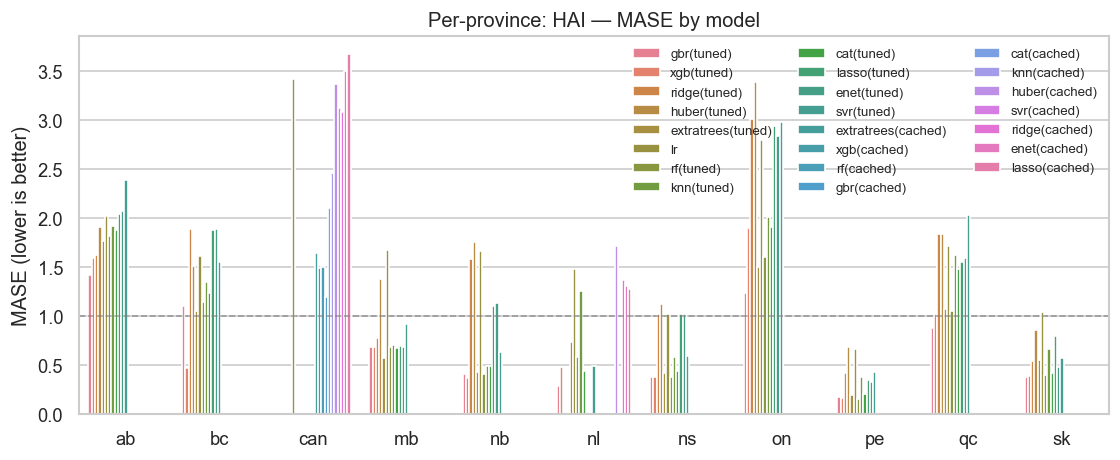

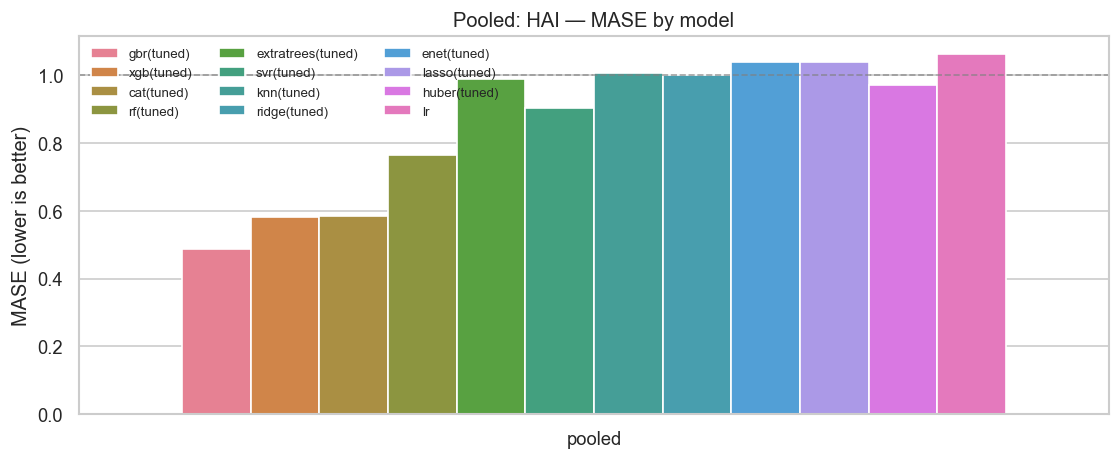

,province,model,RMSE,MAE,MASE,R2_test
0,ab,gbr(tuned),0.749236,0.488064,1.419178,0.586392
12,bc,xgb(tuned),0.338066,0.236102,0.466399,0.919783
24,can,extratrees(cached),0.836682,0.516889,1.643876,0.587341
36,mb,extratrees(tuned),0.651738,0.444773,0.577833,0.644829
48,nb,xgb(tuned),0.751505,0.547509,0.370749,0.654000
60,nl,gbr(tuned),0.432566,0.293932,0.284917,0.824716
72,ns,rf(tuned),0.738669,0.512919,0.380831,0.651345
84,on,gbr(tuned),0.720710,0.423534,1.234124,0.732018
96,pe,rf(tuned),0.257908,0.207726,0.155019,0.903989
108,qc,extratrees(tuned),0.867692,0.617867,1.072150,0.650813


,province,model,MAE,RMSE,sMAPE(%),MASE,R2_test,params
0,pooled,gbr(tuned),0.407153,0.629694,42.75737,0.488047,0.737238,"{'learning_rate': 0.03, 'max_depth': 3, 'n_est..."


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):


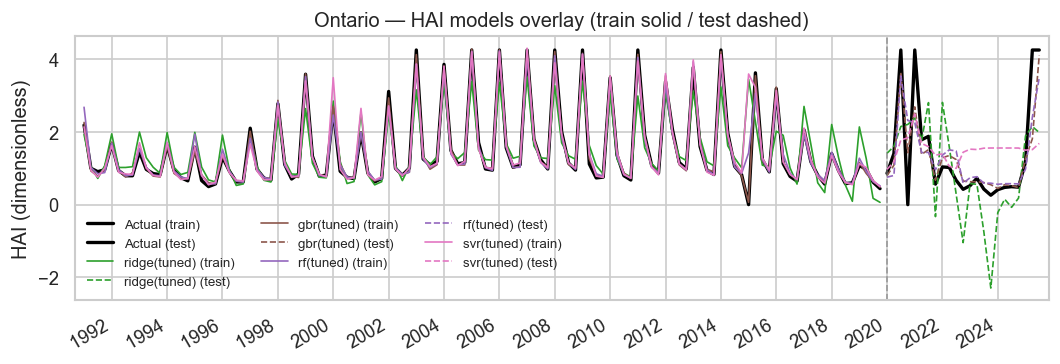

In [21]:
# %% [code]
plot_model_bars(per_metrics_hai, title="Per-province: HAI — MASE by model")
plot_model_bars(pool_metrics_hai.assign(province="pooled"), title="Pooled: HAI — MASE by model")

best_per_hai = (
    per_metrics_hai.sort_values(["province","RMSE"])
    .groupby("province").head(1)[["province","model","RMSE","MAE","MASE","R2_test"]]
)
display(best_per_hai)

best_pooled_hai = pool_metrics_hai.sort_values("RMSE").head(1)
display(best_pooled_hai)

# Example province overlay (swap models as available)
overlay_models_one_province(
    df_feat, per_preds_hai, province="on",
    models=["ridge(tuned)","gbr(tuned)","rf(tuned)","svr(tuned)"],
    title_suffix="(train solid / test dashed)"
)


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_15950/2242183730.py:21: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.Pe

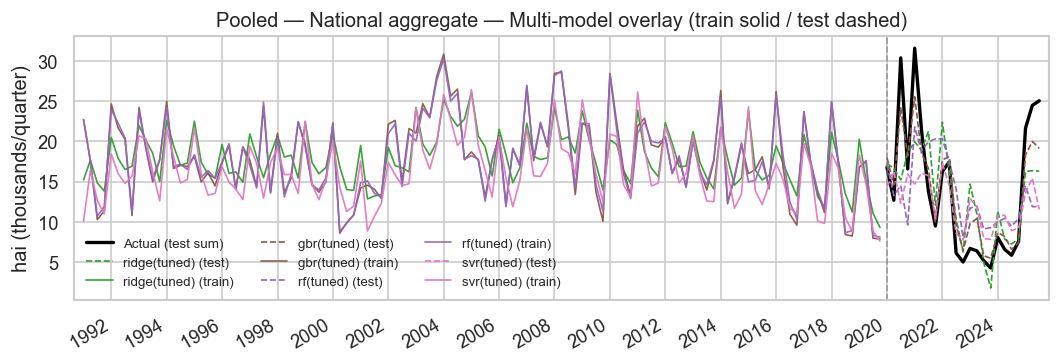

In [24]:
# Example pooled overlay (national aggregate)
overlay_models_pooled(
    df_feat, pool_preds_hai,
    models=["ridge(tuned)","gbr(tuned)","rf(tuned)","svr(tuned)"],
    title_suffix="(train solid / test dashed)"
)